In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

In [2]:
import csv
import torch
import torchtext
import spacy
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from torch.utils.data import random_split
from torchtext.data import Field, BucketIterator, TabularDataset, interleave_keys, Example

In [89]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [90]:
nlp = spacy.load('en_core_web_lg')

disable_pipeline = ['tok2vec', 'parser', 'senter', 'ner']
nlp.add_pipe('token_splitter')

DATAPATH = './classification.csv'

def tokenize(text):
    doc = nlp(text, disable=disable_pipeline)
    return [t.lemma_ for t in doc if t.is_alpha]

desc = Field(
    init_token='<sos>',
    eos_token='<eos>',
    lower=True,
    tokenize=tokenize,
    stop_words=nlp.Defaults.stop_words
)
cwe = Field(
    sequential=False,
)

In [93]:
desc.build_vocab(dataset, min_freq = 2)
cwe.build_vocab(dataset)

In [91]:
dataset = TabularDataset(
    #path='./drive/MyDrive/data/classification.csv',
    path=DATAPATH,
    format='csv', 
    fields=[('desc', desc), ('cwe', cwe)],
    csv_reader_params={'delimiter': '|'}
)

In [92]:
train_dataset, test_dataset, check_dataset = random_split(
    dataset, lengths=[277134, 69219, 64],
    generator=torch.Generator().manual_seed(42))
train_dataset.fields = dataset.fields
test_dataset.fields = dataset.fields
check_dataset.fields = dataset.fields

In [110]:
BATCH_SIZE = 8

train_iterator, test_iterator, check_iterator = BucketIterator.splits(
    datasets=(train_dataset, test_dataset, check_dataset),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: interleave_keys(len(x.desc), len(x.cwe)),
    shuffle=True,
    device=device,
)

In [319]:
a = torch.tensor([[1,2,3]])
a.view((1, *a.shape)).shape[1:]

torch.Size([1, 3])

In [373]:
def sum_embeddings(x):
    return (x.sum(dim=0) / x.shape[0]).view((1, *x.shape[1:]))

class LSTMForwardNet(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, dropout, n_layers, bidirectional=False, linear_size_tuple = None):
        super().__init__()
        self.embeding = nn.Embedding(input_size, embed_size, padding_idx=desc.vocab['<pad>'])
        if linear_size_tuple is None:
            raise AttributeError('linear_size_tuple should be tuple of ints')
            
            
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        
        rnn = nn.LSTM(
            embed_size, hidden_size, n_layers, 
            dropout=dropout, bidirectional=bidirectional)
        
        layer_sizes = [hidden_size]
        layer_sizes.extend(linear_size_tuple)
        linear = []
        for size in zip(layer_sizes, layer_sizes[1:]):
            in_feature, out_feature = size
            linear.append(nn.Dropout())
            #linear.append(nn.BatchNorm1d(in_feature))
            linear.append(nn.Linear(in_feature, out_feature))
            linear.append(nn.Softmax(dim=2))
        linear = nn.Sequential(*linear)
        
        self.model = nn.ModuleDict({
            'lstm': rnn,
            'linear': linear})
        
    def forward(self, x):
        output, _ = self.model['lstm'](self.embeding(x))
        logits = self.model['linear'](sum_embeddings(output))
        return logits
    
    def init_hidden(self, batch_size, device):
            return(torch.zeros(2 if self.bidirectional else 1, batch_size, self.hidden_size).to(device).requires_grad_(True).double(),
                   torch.zeros(2 if self.bidirectional else 1, batch_size, self.hidden_size).to(device).requires_grad_(True).double())

In [393]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    
    epoch_loss = 0
    epoch_history = []
    total = 0
    epoch_accuracy = 0
    for i, batch in enumerate(tqdm(iterator)):
        x = batch.desc
        y = batch.cwe
        
        total += y.shape[0]
        
        optimizer.zero_grad()
        
        output = model(x)
        output = output.view(output.shape[1:])
        prediction = output.topk(1).indices
        epoch_accuracy += torch.sum(prediction == y)
        loss = criterion(output, y)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        epoch_history.append(loss.cpu().data.numpy())
        
    return epoch_loss / len(iterator), epoch_history, epoch_accuracy / total

In [394]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            in_feature = batch.desc
            expected = batch.cwe

            output = model(in_feature)
            output = output.view(output.shape[1:])
            
            loss = criterion(output, expected)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [399]:
import time
import math

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train_with_evaluation(model, epoch_num, optimizer, criterion, clip, train_iterator, test_iterator, writer):
    train_history = []
    test_history = []
    train_epoch_history = []
    best_valid_loss = 9999.99
    
    for epoch in range(epoch_num):
    
        start_time = time.time()

        train_loss, epoch_history, train_epoch_accuracy = train(model, train_iterator, optimizer, criterion, clip)
        valid_loss = evaluate(model, test_iterator, criterion)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'cwe-model.pt')

        train_history.append(train_loss)
        test_history.append(valid_loss)
        train_epoch_history.append(epoch_history)

        writer.writerow(
            (epoch+1,                           # epoch num
             f'{epoch_mins}:{epoch_secs}',      # epoch time
             f'{train_loss:.3f}',               # train loss
             f'{math.exp(train_loss):7.3f}',    # ppl train
             f'{valid_loss:.3f}',               # valid loss
             f'{math.exp(valid_loss):7.3f}',    # ppl valid
        ))
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Accuracy {train_epoch_accuracy:.3f} | Valid')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tVal. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    return train_history, test_history, train_epoch_history

In [400]:
EPOCH = 10
INPUT_SIZE = len(desc.vocab)
OUTPUT_SIZE = len(cwe.vocab)
EMBED_SIZE = 300
HIDDEN_SIZE = 512
DROPOUT=0.7
N_LAYERS = 1
CLIP_GRAD= 1.0
LINEAR_SIZE_TUPLE= (1024, 512, OUTPUT_SIZE)

model = LSTMForwardNet(
    INPUT_SIZE, EMBED_SIZE, HIDDEN_SIZE, DROPOUT, N_LAYERS, linear_size_tuple=LINEAR_SIZE_TUPLE).to(device)

def init_weights(m):
    for name, params in m.named_parameters():
        torch.nn.init.uniform_(params, -0.08, 0.08)
        
model.apply(init_weights)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [401]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 30,226,881 trainable parameters


In [402]:
with open('cwe_metrics.csv', 'w') as file:
    writer = csv.writer(file, delimiter=';')
    train_with_evaluation(model, EPOCH, optimizer, criterion,
                          CLIP_GRAD, check_iterator, check_iterator, writer)

  0%|                                                                                                                                                          | 0/8 [00:00<?, ?it/s]

x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])


 25%|████████████████████████████████████▌                                                                                                             | 2/8 [00:00<00:01,  4.73it/s]

x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 4/8 [00:00<00:00,  4.52it/s]

x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])


 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 5/8 [00:01<00:00,  4.29it/s]

x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 6/8 [00:01<00:00,  3.98it/s]

x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7/8 [00:01<00:00,  3.54it/s]

x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.57it/s]


x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])
Epoch: 01 | Time: 0m 2s
	Accuracy 0.016
	Train Loss: 5.595 | Train PPL: 269.000
	Val. Loss: 5.595 |  Val. PPL: 268.989


 12%|██████████████████▎                                                                                                                               | 1/8 [00:00<00:01,  6.14it/s]

x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])


 38%|██████████████████████████████████████████████████████▊                                                                                           | 3/8 [00:00<00:00,  5.61it/s]

x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 4/8 [00:00<00:00,  4.93it/s]

x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])


 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 5/8 [00:00<00:00,  4.90it/s]

x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([46, 8, 512])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 6/8 [00:01<00:00,  4.83it/s]

a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7/8 [00:01<00:00,  4.33it/s]

x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.37it/s]


x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])
Epoch: 02 | Time: 0m 2s
	Accuracy 0.156
	Train Loss: 5.595 | Train PPL: 268.981
	Val. Loss: 5.595 |  Val. PPL: 268.970


  0%|                                                                                                                                                          | 0/8 [00:00<?, ?it/s]

x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])


 12%|██████████████████▎                                                                                                                               | 1/8 [00:00<00:00,  7.13it/s]

x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])


 25%|████████████████████████████████████▌                                                                                                             | 2/8 [00:00<00:00,  6.88it/s]

x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])


 38%|██████████████████████████████████████████████████████▊                                                                                           | 3/8 [00:00<00:00,  6.17it/s]

x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 4/8 [00:00<00:00,  5.74it/s]

x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 6/8 [00:01<00:00,  5.24it/s]

x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7/8 [00:01<00:00,  4.51it/s]

x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.69it/s]


x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])
Epoch: 03 | Time: 0m 2s
	Accuracy 0.141
	Train Loss: 5.595 | Train PPL: 268.962
	Val. Loss: 5.595 |  Val. PPL: 268.950


 12%|██████████████████▎                                                                                                                               | 1/8 [00:00<00:01,  5.93it/s]

x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])


 38%|██████████████████████████████████████████████████████▊                                                                                           | 3/8 [00:00<00:00,  6.15it/s]

x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])


 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 5/8 [00:00<00:00,  5.09it/s]

x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 6/8 [00:01<00:00,  4.85it/s]

x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7/8 [00:01<00:00,  4.44it/s]

x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.50it/s]


x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])
Epoch: 04 | Time: 0m 2s
	Accuracy 0.156
	Train Loss: 5.594 | Train PPL: 268.941
	Val. Loss: 5.594 |  Val. PPL: 268.929


  0%|                                                                                                                                                          | 0/8 [00:00<?, ?it/s]

x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])


 12%|██████████████████▎                                                                                                                               | 1/8 [00:00<00:01,  6.10it/s]

x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])


 25%|████████████████████████████████████▌                                                                                                             | 2/8 [00:00<00:01,  5.87it/s]

x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])


 38%|██████████████████████████████████████████████████████▊                                                                                           | 3/8 [00:00<00:00,  5.63it/s]

x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])


 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 5/8 [00:00<00:00,  4.82it/s]

x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 6/8 [00:01<00:00,  4.38it/s]

x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7/8 [00:01<00:00,  3.68it/s]

x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.03it/s]


x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])
Epoch: 05 | Time: 0m 2s
	Accuracy 0.188
	Train Loss: 5.594 | Train PPL: 268.920
	Val. Loss: 5.594 |  Val. PPL: 268.908


  0%|                                                                                                                                                          | 0/8 [00:00<?, ?it/s]

x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])


 12%|██████████████████▎                                                                                                                               | 1/8 [00:00<00:01,  6.06it/s]

x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])


 25%|████████████████████████████████████▌                                                                                                             | 2/8 [00:00<00:01,  5.32it/s]

x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])


 38%|██████████████████████████████████████████████████████▊                                                                                           | 3/8 [00:00<00:00,  5.22it/s]

x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 4/8 [00:00<00:00,  5.33it/s]

x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 6/8 [00:01<00:00,  4.92it/s]

x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7/8 [00:01<00:00,  4.44it/s]

x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.25it/s]


x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])
Epoch: 06 | Time: 0m 2s
	Accuracy 0.297
	Train Loss: 5.594 | Train PPL: 268.899
	Val. Loss: 5.594 |  Val. PPL: 268.887


  0%|                                                                                                                                                          | 0/8 [00:00<?, ?it/s]

x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])


 12%|██████████████████▎                                                                                                                               | 1/8 [00:00<00:01,  6.76it/s]

x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])


 25%|████████████████████████████████████▌                                                                                                             | 2/8 [00:00<00:00,  6.75it/s]

x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 4/8 [00:00<00:00,  5.02it/s]

x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 6/8 [00:01<00:00,  4.49it/s]

x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7/8 [00:01<00:00,  3.89it/s]

x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.95it/s]


x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])
Epoch: 07 | Time: 0m 2s
	Accuracy 0.359
	Train Loss: 5.594 | Train PPL: 268.878
	Val. Loss: 5.594 |  Val. PPL: 268.864


  0%|                                                                                                                                                          | 0/8 [00:00<?, ?it/s]

x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])


 12%|██████████████████▎                                                                                                                               | 1/8 [00:00<00:01,  6.46it/s]

x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])


 25%|████████████████████████████████████▌                                                                                                             | 2/8 [00:00<00:01,  5.61it/s]

x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])


 38%|██████████████████████████████████████████████████████▊                                                                                           | 3/8 [00:00<00:00,  5.57it/s]

x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 4/8 [00:00<00:00,  5.27it/s]

x.shape=torch.Size([39, 8, 512])


 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 5/8 [00:00<00:00,  5.20it/s]

a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([46, 8, 512])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 6/8 [00:01<00:00,  4.97it/s]

a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7/8 [00:01<00:00,  3.68it/s]

x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.17it/s]


x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])
Epoch: 08 | Time: 0m 2s
	Accuracy 0.375
	Train Loss: 5.594 | Train PPL: 268.853
	Val. Loss: 5.594 |  Val. PPL: 268.841


  0%|                                                                                                                                                          | 0/8 [00:00<?, ?it/s]

x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])


 12%|██████████████████▎                                                                                                                               | 1/8 [00:00<00:00,  7.18it/s]

x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])


 25%|████████████████████████████████████▌                                                                                                             | 2/8 [00:00<00:00,  6.61it/s]

x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])


 38%|██████████████████████████████████████████████████████▊                                                                                           | 3/8 [00:00<00:00,  6.32it/s]

x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 4/8 [00:00<00:00,  5.90it/s]

x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])


 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 5/8 [00:00<00:00,  5.49it/s]

x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 6/8 [00:01<00:00,  5.11it/s]

x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7/8 [00:01<00:00,  4.32it/s]

x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.61it/s]


x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])
Epoch: 09 | Time: 0m 2s
	Accuracy 0.375
	Train Loss: 5.594 | Train PPL: 268.831
	Val. Loss: 5.594 |  Val. PPL: 268.818


  0%|                                                                                                                                                          | 0/8 [00:00<?, ?it/s]

x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])


 12%|██████████████████▎                                                                                                                               | 1/8 [00:00<00:01,  6.49it/s]

x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])


 25%|████████████████████████████████████▌                                                                                                             | 2/8 [00:00<00:00,  6.32it/s]

x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])


 38%|██████████████████████████████████████████████████████▊                                                                                           | 3/8 [00:00<00:00,  5.84it/s]

x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 4/8 [00:00<00:00,  5.69it/s]

x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 6/8 [00:01<00:00,  4.89it/s]

x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7/8 [00:01<00:00,  4.08it/s]

x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.20it/s]


x.shape=torch.Size([18, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([22, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([30, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([34, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([39, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([46, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([68, 8, 512])
a.shape=torch.Size([1, 8, 512])
x.shape=torch.Size([105, 8, 512])
a.shape=torch.Size([1, 8, 512])
Epoch: 10 | Time: 0m 2s
	Accuracy 0.375
	Train Loss: 5.594 | Train PPL: 268.808
	Val. Loss: 5.594 |  Val. PPL: 268.793


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('cwe_metrics.csv', delimiter=';')

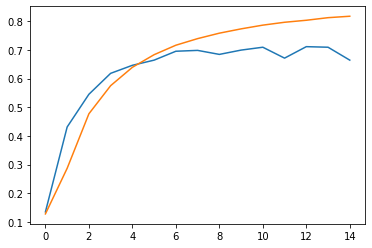

In [7]:
plt.plot(df['val. acc.'])
plt.plot(df['train acc.'])


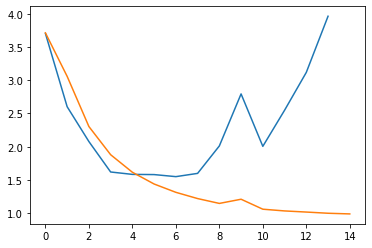

In [12]:
plt.plot(df['val. loss'][:-1])
plt.plot(df['train loss'])